In [27]:
import GPy
import GPyOpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


This corresponds to trying to optimise an unknown machine learning model. However, the initialization of the model is very important, meaning your observations will be very noisy, and the problem might have a lot of local optima! You are trying to make the model’s log-likelihood as large as possible.

In [28]:
def load_initial_data(inputs_file, outputs_file) -> pd.DataFrame:
    X = np.load(inputs_file)
    y = np.load(outputs_file)
    df = pd.DataFrame(X, columns=['x1', 'x2'])
    df['y'] = y
    return df

df1 = load_initial_data(
    '../initial_data/function_2/initial_inputs.npy',
    '../initial_data/function_2/initial_outputs.npy',
)
df2 = load_initial_data(
    '../initial_data2/function_2/initial_inputs.npy',
    '../initial_data2/function_2/initial_outputs.npy',
)

df = pd.concat([df1, df2], ignore_index=True)

df.head()


,x1,x2,y
0,0.665800,0.123969,0.538996
1,0.877791,0.778628,0.420586
2,0.142699,0.349005,-0.065624
3,0.845275,0.711120,0.293993
4,0.454647,0.290455,0.214965


In [29]:
import re

df_feedback = pd.read_csv('../initial_data/561_data.csv')

df_feedback = df_feedback[['f2', 'f2_output']]
df_feedback['f2'] = df_feedback['f2'].apply(lambda x: re.findall(r'\d+\.\d*', x))

for i in range(len(df_feedback['f2'].iloc[0])):
    df_feedback[f'x{i+1}'] = df_feedback['f2'].apply(lambda x: float(x[i]))

df_feedback.drop('f2', axis=1, inplace=True)
df_feedback = df_feedback.rename(columns={'f2_output': 'y'})
df_feedback = df_feedback[['x1', 'x2', 'y']]

df = pd.concat([df, df_feedback], ignore_index=True)
df.describe()

,x1,x2,y
count,27.000000,27.000000,27.000000
mean,0.418909,0.419709,0.211328
std,0.248473,0.250052,0.252028
min,0.063025,0.028698,-0.065624
25%,0.200949,0.244735,0.015728
50%,0.341750,0.356543,0.064275
75%,0.662464,0.582205,0.421302
max,0.877791,0.926564,0.694832


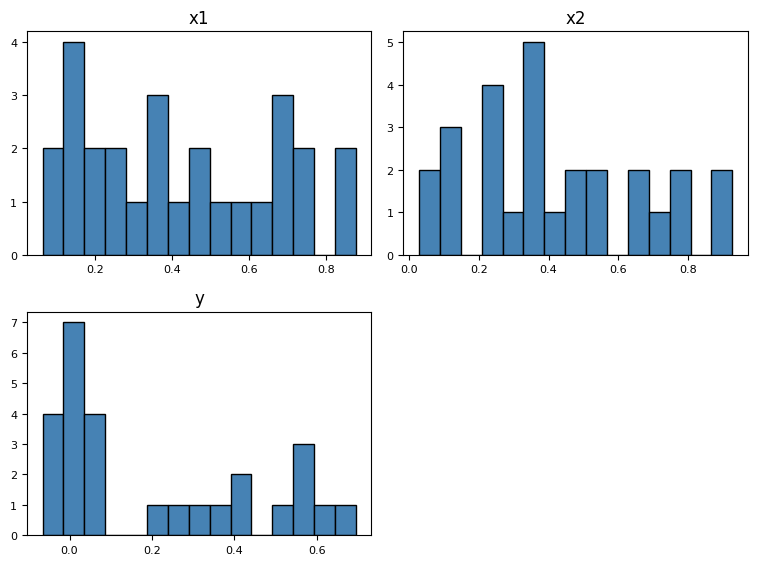

In [30]:
df.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

In [31]:
def analyse_param(df, x, y):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))

    # Plot histogram
    axes[0].set_xlabel(x)
    axes[0].set_ylabel("Frequency")
    axes[0].hist(df[x], bins=15, color='steelblue', edgecolor='black', linewidth=1.0)

    # Plot density
    axes[1].set_xlabel(x)
    axes[1].set_ylabel("Frequency")
    sns.kdeplot(df[x], ax=axes[1], color='steelblue', shade=True, legend=False)

    # Plot scatter
    axes[2].set_xlabel(x)
    axes[2].set_ylabel(y)
    axes[2].scatter(df[x], df[y], s=30, edgecolor='black', alpha=0.7)

    plt.tight_layout()
    plt.show()


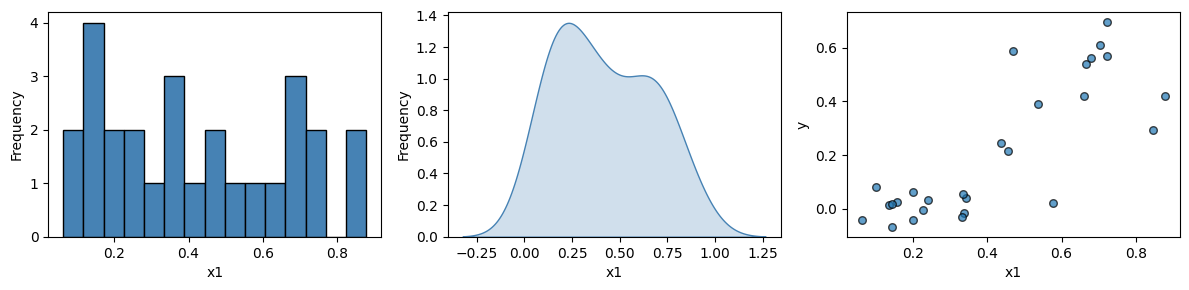

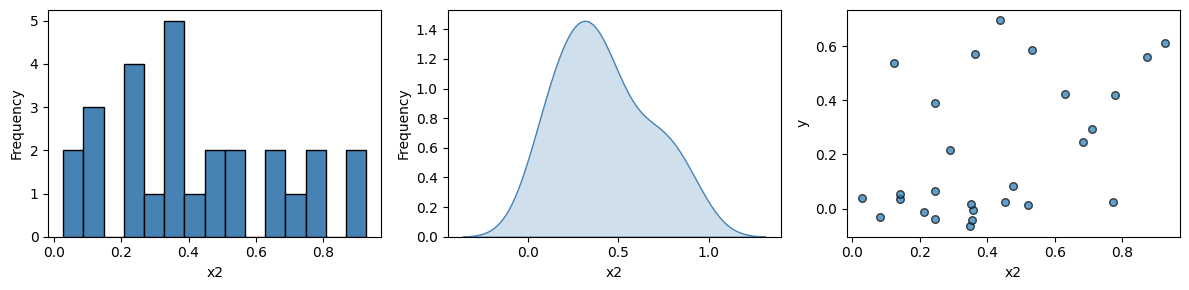

In [32]:
analyse_param(df, 'x1', 'y')
analyse_param(df, 'x2', 'y')

In [33]:
def analyse_corr_to_y(df):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot correlation to y
    corr = df.corr()
    sns.heatmap(corr[['y']], annot=True, cmap='coolwarm', ax=axes[0])

    # Plot scatter
    axes[1].set_xlabel("x1")
    axes[1].set_ylabel("x2")
    axes[1].scatter(df['x1'], df['x2'], s=30, edgecolor='black', c=df['y'], cmap='coolwarm', alpha=0.7)

    plt.tight_layout()
    plt.show()

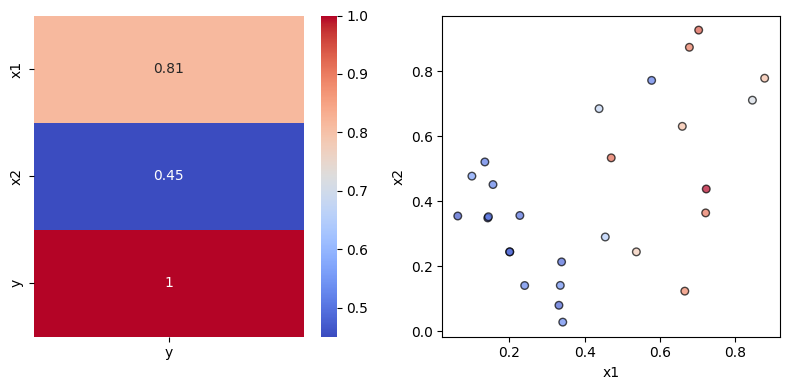

In [34]:
analyse_corr_to_y(df)

In [35]:
def pairwise_relationship(df):
    sns.pairplot(df, kind='scatter', diag_kind='kde', plot_kws={'alpha': 0.7, 's': 30, 'edgecolor': 'black'})
    plt.tight_layout()
    plt.show()

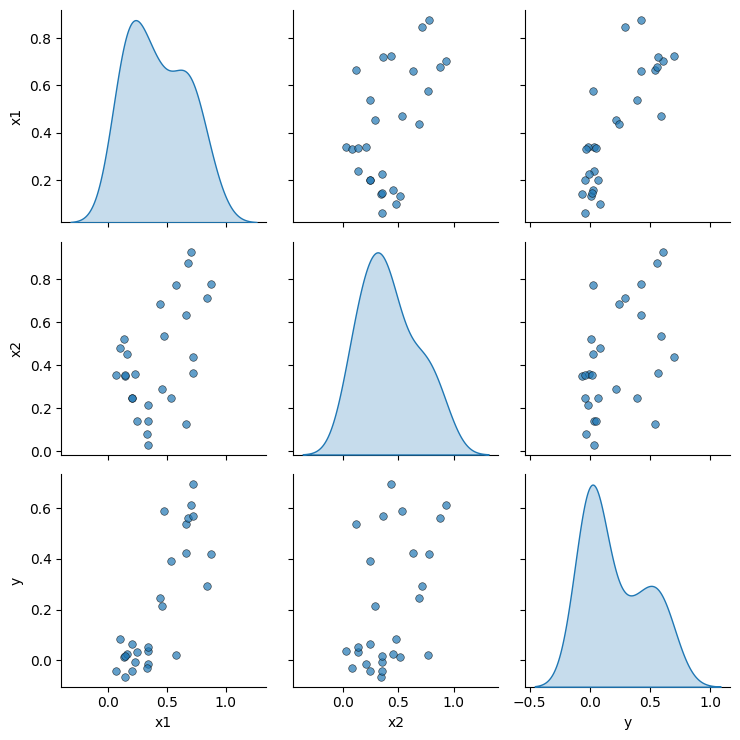

In [36]:
pairwise_relationship(df)

In [37]:
def objective_fn(x):
    return -(np.array([x[:, 0] + x[:, 1]]).T)

objective = GPyOpt.core.task.SingleObjective(objective_fn)

space = GPyOpt.Design_space(
    space=[{'name': 'x1', 'type': 'continuous', 'domain': (0, 0.999999)},
           {'name': 'x2', 'type': 'continuous', 'domain': (0, 0.999999)}]
)

gp_kernel = GPy.kern.Matern32(
    input_dim=2,
    variance=1.0,
    lengthscale=1.0
)

model = GPyOpt.models.GPModel(
    exact_feval=False,
    optimize_restarts=5,
    verbose=False,
    kernel=gp_kernel
)

acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)

initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

acquisition = GPyOpt.acquisitions.AcquisitionEI(model, space, acquisition_optimizer, jitter=0.01)

evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

bo = GPyOpt.methods.ModularBayesianOptimization(
    model, space, objective, acquisition, evaluator,
    X_init=df[['x1', 'x2']].values,
    Y_init=df['y'].values.reshape(-1, 1),
    de_duplication=True
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


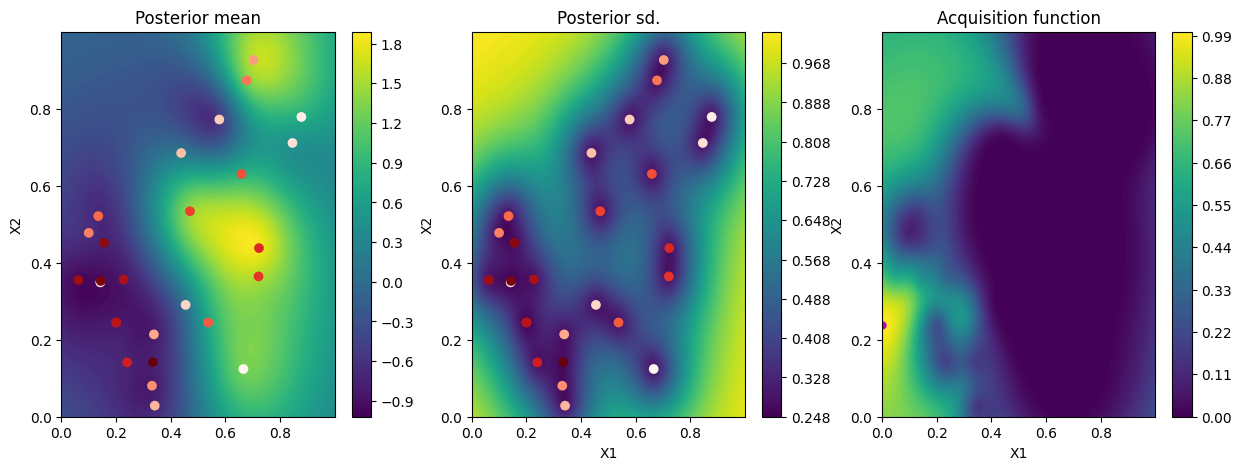

In [38]:
bo.plot_acquisition()

In [39]:
x_next = bo.suggest_next_locations()
print(f"next_query: {'-'.join(['%.6f' % x for x in x_next[0]])}")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
